In [2]:
from datetime import timedelta, datetime 
import glob
from itertools import chain
import json
import os
import re

import numpy as np
import pandas as pd

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


# from wordcloud import WordCloud
# import matplotlib.pyplot as plt
# wordcloud = WordCloud(font_path='font/NanumGothic.ttf', background_color='white').generate(text)


# font_path = 'C:\Users\medici\anaconda3\lib\site-packages\matplotlib\mpl-data\matplotlib\rcNanumGothic.ttf'
# font_name = fm.FontProperties(fname=font_path, size=10).get_name()
# plt.rc('font', family=font_name, size=12)
plt.rcParams["figure.figsize"] = (20, 10)
register_matplotlib_converters()

mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumGothic')

In [3]:
pd.options.mode.chained_assignment = None

## 1. 곡 장르 코드 데이터 : `genre_gn_all.json`

In [5]:
genre_gn_all = pd.read_json('data/genre_gn_all.json', typ = 'series') # 장르 읽어오기

# 장르코드 : gnr_code, 장르명 : gnr_name
genre_gn_all = pd.DataFrame(genre_gn_all, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'})

### 대분류 장르코드 

In [6]:
# 장르코드 뒷자리 두 자리가 00인 코드를 필터링
gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] == '00']

#describe() 
gnr_code.describe()

,gnr_code,gnr_name
count,30,30
unique,30,26
top,GN0100,랩/힙합
freq,1,2


> **장르 이름(unique) 5개 중복**   
하기와 같음
>> 12	GN0300	랩/힙합, 90	GN1200	랩/힙합      
18	GN0400	R&B/Soul, 100	GN1300	R&B/Soul    
32	GN0600	록/메탈, 65	GN1000	록/메탈    
50	GN0800	포크/블루스, 109	GN1400	포크/블루스/컨트리 => 얘만 3개야       
80	GN1100	일렉트로니카, 232	GN2600	일렉트로니카  
   
>**시사점) 뒷번호에 나오는 같은 이름의 장르는 외국노래만 모아놓은 장르이다.    
> 추가적으로 2019년에 멜론은 장르 

---

### 상세 장르코드

In [6]:
# 장르코드 뒷자리 두 자리가 00이 아닌 코드를 필터링
dtl_gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] != '00']
dtl_gnr_code.rename(columns = {'gnr_code' : 'dtl_gnr_code', 'gnr_name' : 'dtl_gnr_name'}, inplace = True)

### 장르 코드 트리(Tree)

In [7]:
# 앞자리 네 자리 공통코드 추출
gnr_code = gnr_code.assign(join_code = gnr_code['gnr_code'].str[0:4])
dtl_gnr_code = dtl_gnr_code.assign(join_code = dtl_gnr_code['dtl_gnr_code'].str[0:4])

# Merge
gnr_code_tree = pd.merge(gnr_code, dtl_gnr_code, how = 'left', on = 'join_code')

# gnr_code_tree[['gnr_code', 'gnr_name', 'dtl_gnr_code', 'dtl_gnr_name']].T

---
`2.크리스마스 장르(GN3000)의 세부장르 NaN값`

In [8]:
# 크리스마스 장르(GN3000)의 세부장르 NaN값
gnr_code_tree[gnr_code_tree['gnr_code'] == 'GN3000']

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
224,GN3000,크리스마스,GN30,NaN,NaN


> **dtl_gnr_code, dtl_gnr_name NaN값을 가짐 => 장르 만들어주기**

---

`3. 어린이/테교 장르(GN2200)에 상세장르인 영어동요 중복됨` 

In [18]:
# 어린이/테교 장르(GN2200)에 상세장르인 영어동요 중복 
gnr_code_tree[gnr_code_tree['gnr_code'] == 'G2200']

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name


> **같은 대분류 속 상세분류(dtl_gnr_name)가 중복되기도 함.   
179	GN2200	어린이/태교	GN22	GN2203	영어동요   
180	GN2200	어린이/태교	GN22	GN2204	영어동요   
181	GN2200	어린이/태교	GN22	GN2205	영어동요**   
세부장르 년도 + 장르 / 장르 / 년도.

---
---
## 2. 곡 별 메타 데이터 : `song_meta.json`

In [23]:
song_meta = pd.read_json('song_meta.json', typ = 'frame')

In [24]:
song_meta.head().T

,0,1,2,3,4
song_gn_dtl_gnr_basket,[GN0901],"[GN1601, GN1606]",[GN0901],"[GN1102, GN1101]","[GN1802, GN1801]"
issue_date,20140512,20080421,20180518,20151016,20110824
album_name,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,"Bach : Partitas Nos. 2, 3 & 4",Hit,Feeling Right (Everything Is Nice) (Feat. Popc...,그남자 그여자
album_id,2255639,376431,4698747,2644882,2008470
artist_id_basket,[2727],[29966],[3361],[838543],[560160]
song_name,Feelings,"Bach : Partita No. 4 In D Major, BWV 828 - II....",Solsbury Hill (Remastered 2002),Feeling Right (Everything Is Nice) (Feat. Popc...,그남자 그여자
song_gn_gnr_basket,[GN0900],[GN1600],[GN0900],[GN1100],[GN1800]
artist_name_basket,[Various Artists],[Murray Perahia],[Peter Gabriel],[Matoma],[Jude Law]
id,0,1,2,3,4


---
`4. 발매년도 만들기 str타입`

In [25]:
# 발매년도 만들기 str타입
song_meta['issue_date'] = song_meta['issue_date'].astype(str)
song_meta['issue_year'] = song_meta['issue_date'].str[:4]

> 발매년도를 만들어서 년도별 grouping 후에     
년도 별 장르 frequency를 알아보려고 했는데 코드를 어케 짤지 모르겠음..   

>활용) 이후 추천서비스 plylist에 '추억' 단어가 들어갈 때 세대별 추억 노래 추천

---
`5. 자연어처리 시 주의할 사항 정리`

In [26]:
song_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707989 entries, 0 to 707988
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  707989 non-null  object
 1   issue_date              707989 non-null  object
 2   album_name              707985 non-null  object
 3   album_id                707989 non-null  int64 
 4   artist_id_basket        707989 non-null  object
 5   song_name               707989 non-null  object
 6   song_gn_gnr_basket      707989 non-null  object
 7   artist_name_basket      707989 non-null  object
 8   id                      707989 non-null  int64 
 9   issue_year              707989 non-null  object
dtypes: int64(2), object(8)
memory usage: 54.0+ MB


- **총 707,989곡의 메타 정보가 담겨 있으며** 포함하는 값은 아래와 같습니다.
  + `song_gn_dtl_gnr_basket` : 상세 장르 코드
  + `issue_date` : 곡 발매 일자 (yyyymmdd)
  + `album_name` : 앨범 명
  + `album_id` : 앨범 아이디
  + `artist_id_basket` : 아티스트 아이디 (복수일 경우 띄어쓰기로 구분)
  + `song_name` : 곡 명
  + `song_gn_gnr_basket` : 대분류 장르코드
  + `artist_name_basket` : 아티스트 명 (복수일 경우 띄어쓰기로 구분)
  + `id` : 곡 아이디
 
> **album_name, song_name, artist_name_basket 영어, 한국어 혼합 및 형태소 분석 주의**    

> **song_gn_dtl_gnr_basket xx01 대분류장르코드는 모든 곡에 공통 들어가있다.(크리스마스곡 제외)**   

> **리스트로 묶여있는 칼럼 목록 : song_gn_dtl_gnr_basket, artist_id_basket, song_gn_gnr_basket, artist_name_basket**   

---
`6. 카테고리, 뉴머릭 컬럼 분류`     
`뉴머릭컬럼은 의미없는 단순 숫자 컬럼`

In [27]:
# 카테고리, 뉴머릭 컬럼 분류   
# 뉴머릭컬럼은 의미없는 단순 숫자 컬럼
cat_columns = [c for c, t in zip(song_meta.dtypes.index, song_meta.dtypes) if t=='O'] 
num_columns = [c for c in song_meta.columns if c not in cat_columns]

print(f'Categorical Columns: \n{cat_columns}\n')
print(f'Numeric Columns: \n{num_columns}\n')

Categorical Columns: 
['song_gn_dtl_gnr_basket', 'issue_date', 'album_name', 'artist_id_basket', 'song_name', 'song_gn_gnr_basket', 'artist_name_basket', 'issue_year']

Numeric Columns: 
['album_id', 'id']



---
`7. album_name 이상치 제거필요`

In [28]:
song_meta[song_meta['album_name'].isnull()]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,issue_year
143209,"[GN0501, GN0601, GN0503, GN0606, GN0509]",20150522,None,2318271,[726168],사랑바보,"[GN0500, GN0600]",[민은서밴드],143209,2015
291631,"[GN0105, GN0101]",20101108,None,1065178,[28772],빗속에서,[GN0100],[존박],291631,2010
431110,"[GN0509, GN0601, GN0503, GN0606, GN0501]",20200208,None,10385717,[2203064],화면,"[GN0500, GN0600]",[Oowl Hannal (우울 한날)],431110,2020
552088,"[GN0105, GN0601]",20101108,None,1065178,[28263],본능적으로 (Feat. Swings),"[GN0600, GN0100]",[강승윤],552088,2010


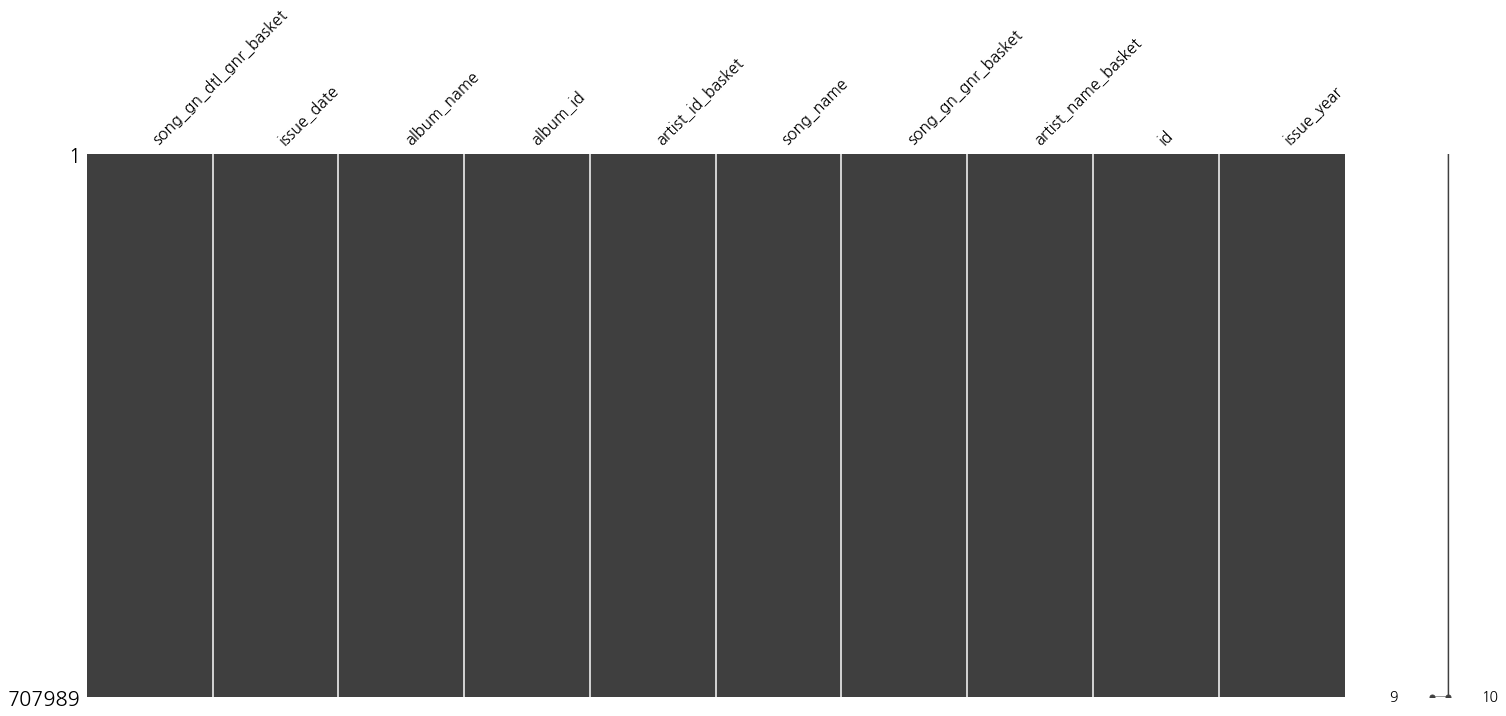

song_gn_dtl_gnr_basket    0.000000
issue_date                0.000000
album_name                0.000565
album_id                  0.000000
artist_id_basket          0.000000
song_name                 0.000000
song_gn_gnr_basket        0.000000
artist_name_basket        0.000000
id                        0.000000
issue_year                0.000000
dtype: float64

In [29]:
import missingno as msno
msno.matrix(song_meta, sort='descending')
plt.show()

song_meta.isna().sum() / len(song_meta) * 100 # NaN, Null

> **album_name 0.000565 소량이지만 결측치 존재
앨범 이름이라 중요하다고 판단되지 않긴함. 다른값으로 채우면 되지않을까?**
---
`9. 중복되는 앨범이름`

In [30]:
print(song_meta['album_name'].value_counts().head())

print(song_meta['album_id'].value_counts().head())

Greatest Hits     930
The Collection    399
Best Of           294
Love Songs        247
Home              236
Name: album_name, dtype: int64
2173174     142
300601      138
10261494    138
324341      136
10058860    114
Name: album_id, dtype: int64


---
## 3. 학습 데이터 : `train.json`

In [31]:
train = pd.read_json('train.json', typ = 'frame')

In [32]:
# train['tags_str'] = train['tags'].map(lambda x : " ".join(x))
# train.head(2)

---
`10. 좋아요를 많이 받은 플레이리스트의 태그 빈도`

In [33]:
top3000df = train.sort_values('like_cnt',ascending = False).head(3000)

In [37]:
top3000_tag_list = np.concatenate( top3000df['tags'].values )
pd.Series(top3000_tag_list).value_counts().tail(20)

그림            1
내일그대와         1
애틋함           1
BossaNova     1
아이슬란드         1
매장노래          1
RESTINPAST    1
RandB         1
소녀감성          1
lit           1
칵테일바          1
핑클            1
쇼핑            1
아쉬움           1
안녕            1
울고싶은날         1
패션피플          1
짜증            1
재즈카페          1
잡념삭제          1
dtype: int64